<a href="https://colab.research.google.com/github/Radhesh-Sarma/Emotion-Detection/blob/main/Genetic_Algorithm_Openface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import random
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn import model_selection
import seaborn as sns
plt.style.use('seaborn')

Mounted at /content/gdrive


In [ ]:
drive.mount('/content/gdrive')

In [2]:
def sigmoid(inpt):
    return 1.0 / (1.0 + numpy.exp(-1 * inpt))

def relu(inpt):
    result = inpt
    result[inpt < 0] = 0
    return result

#Genetic Algorithm

In [3]:
def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

In [4]:
def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint32(offspring_size[1]/2)
    
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [5]:
def mutation(offspring_crossover, mutation_percent):
    num_mutations = numpy.uint32((mutation_percent*offspring_crossover.shape[1])/100)
    mutation_indices = numpy.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))

    # Mutation changes a single gene in each offspring randomly.

    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    return offspring_crossover

# Changing weight matrices to 1-D vectors

In [6]:
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = numpy.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return numpy.array(pop_weights_vector)

# Changing 1-D vectors to weight matrices

In [7]:
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = numpy.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return numpy.reshape(mat_weights, newshape=mat_pop_weights.shape)

# Muliplying weights with input to predict output**

In [8]:
def predict_outputs(weights_mat, data_inputs, data_outputs, activation="relu"):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = r1 @ curr_weights
            if activation == "relu":
                r1 = relu(r1)
            elif activation == "sigmoid":
                r1 = sigmoid(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions/data_outputs.size)*100
    return accuracy, predictions

# Fitness Function

In [9]:
def fitness(weights_mat, data_inp, data_out, activation="relu"):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inp, data_out, activation=activation)
    return accuracy

# Read the dataset 

In [10]:
def normalize(dataset):
    dataNorm=((dataset-dataset.mean())/(dataset.std()))
    dataNorm["Sad?"]=dataset["Sad?"]
    return dataNorm

In [11]:
df = pd.read_csv('gdrive/My Drive/combined.csv')
df=df.drop(['face'],1)
df=df.drop(['Unnamed: 1'],1)
print(df)
  
df = normalize(df)
#df=df.drop('Unnamed: 1',axis=1,inplace=True)

x = np.array(df.drop(['Sad?'],1))
y = np.array(df['Sad?'])
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.2)

data_inputs = x_train
data_outputs = y_train

     Sad?  confidence  gaze_0_x  gaze_0_y  ...  AU25_c  AU26_c  AU28_c  AU45_c
0       1       0.975  0.045100  0.261753  ...     0.0     0.0     1.0     0.0
1       1       0.925  0.058224  0.235082  ...     0.0     0.0     0.0     0.0
2       1       0.975  0.074234  0.026665  ...     0.0     0.0     0.0     0.0
3       1       0.025  0.256086 -0.216004  ...     1.0     0.0     1.0     0.0
4       1       0.975  0.193449  0.209023  ...     0.0     0.0     1.0     0.0
..    ...         ...       ...       ...  ...     ...     ...     ...     ...
121     0       0.875 -0.263258 -0.049040  ...     1.0     0.0     1.0     1.0
122     0       0.775  0.509802 -0.322897  ...     0.0     0.0     1.0     0.0
123     0       0.975  0.183691  0.158997  ...     1.0     1.0     0.0     0.0
124     0       0.975 -0.010093  0.216590  ...     0.0     0.0     1.0     0.0
125     0       0.975  0.145005  0.166456  ...     1.0     0.0     0.0     0.0

[126 rows x 711 columns]


In [12]:
#Genetic algorithm parameters:
sol_per_pop = 8           #Population Size
num_parents_mating = 2    #Mating Pool Size (Number of Parents)
num_generations = 1000    #Number of Generations
mutation_percent = 10     #Mutation Percent

#Creating the initial population.
initial_pop_weights = []

for curr_sol in numpy.arange(0, sol_per_pop):

    HL1_neurons = 150
    input_HL1_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))

    HL2_neurons = 60
    HL1_HL2_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))

    output_neurons = 2
    HL2_output_weights = numpy.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(numpy.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

pop_weights_mat = numpy.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)
best_outputs = []
accuracies = numpy.empty(shape=(num_generations))

In [13]:
for generation in range(num_generations):

    print("Generation : ", generation)
    # converting the solutions from being vectors to matrices.
    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    
    fit = fitness(pop_weights_mat, data_inputs, data_outputs, activation="relu")
    accuracies[generation] = fit[0]

    print("Fitness")
    print(fit)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(pop_weights_vector, fit.copy(), num_parents_mating)

    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))

    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

Streaming output truncated to the last 5000 lines.
  -0.07922575]]
Generation :  853
Fitness
[75. 74. 67. 54. 46. 55. 56. 57.]
Parents
[[ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]]
Crossover
[[ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322  0.02669946  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]]
Mutation
[[ 0.03787322  0.9578263   0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322 -0.66400949  0.0944795  ...  0.08771584  0.06331744
  -0.07922575]
 [ 0.03787322 -0.35889931  0.09447

In [14]:
pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation="relu")
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  75.0


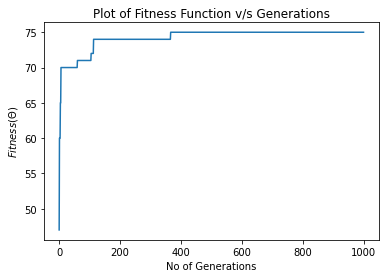

In [15]:
plt.plot(accuracies)
plt.xlabel("No of Generations")
plt.ylabel("$Fitness(\Theta)$")
plt.title("Plot of Fitness Function v/s Generations")
plt.show()

In [16]:
def garson(A, B, C):
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """

    # connection weight through the different hidden node
    cw = np.dot(A, B)
    cw = np.dot(cw, C)

    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

In [17]:
g1=garson(best_weights[0],best_weights[1],best_weights[2])
features=df.columns
Dict = {}
for i in range(1,711):
  Dict[features[i]]=g1[i-1]

In [18]:
import operator
sorted_x = sorted(Dict.items(), key=operator.itemgetter(1),reverse=True)
print("Printing features ranked from most important to least important")
x=0
for i in sorted_x:
  print(x,":",i)
  x=x+1

Printing features ranked from most important to least important
0 : ('X_44', 0.004309900537841652)
1 : ('Z_65', 0.004193819104895677)
2 : ('eye_lmk_y_5', 0.0038155383617162527)
3 : ('x_13', 0.0036967382564090314)
4 : ('eye_lmk_Z_55', 0.0035798772635750186)
5 : ('eye_lmk_x_9', 0.003575317656445098)
6 : ('p_10', 0.0034859116447713157)
7 : ('AU04_c', 0.003462656248721241)
8 : ('eye_lmk_y_48', 0.0034455854852645587)
9 : ('X_12', 0.003430823068414881)
10 : ('Y_20', 0.003420054077786331)
11 : ('Z_59', 0.003414626924001348)
12 : ('p_2', 0.003403857079771)
13 : ('confidence', 0.0033959135944274695)
14 : ('X_45', 0.003382812508410199)
15 : ('p_18', 0.0033404874723672075)
16 : ('p_13', 0.003313206429642544)
17 : ('p_27', 0.0032649259275812858)
18 : ('eye_lmk_Y_4', 0.003248913580979291)
19 : ('Z_48', 0.0032308388670775428)
20 : ('eye_lmk_y_22', 0.003228325949799934)
21 : ('eye_lmk_y_20', 0.0032002182218247087)
22 : ('y_53', 0.003189308931143867)
23 : ('eye_lmk_Y_44', 0.0031733762623322123)
24 : (

In [19]:
data_inputs=x_test
data_outputs=y_test
acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation="relu")
print("Testing Accuracy of the best solution is : ", acc)

Testing Accuracy of the best solution is :  73.07692307692307
